# POPPY Simulation: MagAO-X for PDR
### Status notes:
<b>2017/03/13</b>: Built full file with no compiling errors (FINALLY), but somehow the final PSF is a collimated beam?? Something is obviously wrong. Maybe there's a distance problem still because the focal planes aren't quite reaching to the points.

In [17]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm 
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)

POPPY Version: 0.6.0rc1


## Initiate the optical elements and variables
- (Almost) All values pulled from Laird's MagAO-X design spreadsheet from January 2017. 
- The values for the Magellan telescope (all elements and distances before F/11 focal plane) pulled from Oli's MagAO-X zemax file.

### Optical elements not implemented:
- ADC1 (surface 4&5, 7&8)
- ADC2 (surface 6&7, 9&10)

### To-do for initializing:
- Figure out how PSD is incorporated into POPPY
- Figure out pupil design to add as secondary obscuration

In [18]:
# note: u.m is in meters
testWavelength = 656e-9 * u.m # this may change in the future.
npix = 1024  # resolution

# physical radius values
primary_radius = 3.239204 * u.m # user defined as semi-diameter value
secondary_radius = 0.632573 * u.m # this value is not user defined in zemax, check on this
tertiary_radius = 0.334947 * u.m # this value not user defined in zemax, clarify this.
oap_radius = 0.0254 * u.m # 2 inch diameter OAP
lyot_stop_diam = 0.009 * u.m

# radius of curvature values
primary_roc = 16.26 * u.m
secondary_roc = 2.862820 * u.m

# propagation distances
d_primary_secondary = 9.72205 * u.m
d_secondary_tertiary = 9.02279 * u.m
d_tertiary_f11fp = 4.979516 * u.m 
d_f11fp_oap0 = 0.1434399617 * u.m
d_oap0_woofer = 0.14437519 * u.m
d_woofer_oap1 = 0.2107263437 * u.m
d_oap1_asmfp = 0.2107263437 * u.m
d_asmfp_oap2 = 0.3136327727 * u.m
d_oap2_tweeter = 0.3136327727 * u.m
d_tweeter_oap3 = 1.106254211 * u.m
d_oap3_f57fp = 1.106254211 * u.m
d_f57fp_oap4 = 0.513 * u.m
d_oap4_ttmirror = 0.513 * u.m
d_ttmirror_oap51 = 0.621 * u.m
d_oap51_f69fp = 0.621 * u.m
d_f69fp_oap52 = 0.621 * u.m
d_oap52_lyot = 0.621 * u.m
d_lyot_oap53 = 0.621 * u.m
d_oap53_f69sci = 0.621 * u.m

# OAP mirrors
# All focal lengths are the FS (vertex focus) values in Laird's excel spreadsheet
OAP0 = poppy.QuadraticLens(0.1434399616742 * u.m, name='OAP0')
OAP1 = poppy.QuadraticLens(0.2107263436959 * u.m, name='OAP1')
OAP2 = poppy.QuadraticLens(0.3136327726755 * u.m, name='OAP2')
OAP3 = poppy.QuadraticLens(1.1062542105511 * u.m, name='OAP3')
OAP4 = poppy.QuadraticLens(0.513 * u.m, name='OAP4')
OAP5 = poppy.QuadraticLens(0.621 * u.m, name='OAP5')

primary_mirror = poppy.QuadraticLens(primary_roc/2, name='Primary Mirror')
secondary_mirror = poppy.QuadraticLens(secondary_roc/2, name='Secondary Mirror')

lyotstop = poppy.CircularAperture(radius=lyot_stop_diam/2, name='Lyot Stop')

### Begin MagAO-X system build, inspecting F/11 focal plane

In [19]:
magaox = poppy.FresnelOpticalSystem(pupil_diameter=2*primary_radius, 
                                       npix=npix,
                                       beam_ratio=.34)#beam_ratio is the oversampling convention used in PROPER

entrance=poppy.CircularAperture(radius=primary_radius)
magaox.add_optic(entrance)
# Add line of code here for pupil dimensions but need to get more info about spider + center obscuration

# Surface -6: Primary Mirror
magaox.add_optic(primary_mirror)
magaox.add_optic(poppy.CircularAperture(radius=primary_radius,name="primary mirror aperture"))

# Surface -5: Secondary Mirror
magaox.add_optic(secondary_mirror, distance=d_primary_secondary)
magaox.add_optic(poppy.CircularAperture(radius=secondary_radius,name="secondary mirror aperture"))

# Surface -4: Tertiary mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="tertiary mirror"), distance=d_secondary_tertiary)
magaox.add_optic(poppy.CircularAperture(radius=tertiary_radius, name="tertiary mirror aperture"))

# Surface -3: F/11 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/11 focal plane"), distance=d_tertiary_f11fp)
#magaox.add_optic(poppy.CircularAperture(radius=0.005*u.m, name="F/11 focal plane aperture"))

#magaox.describe()

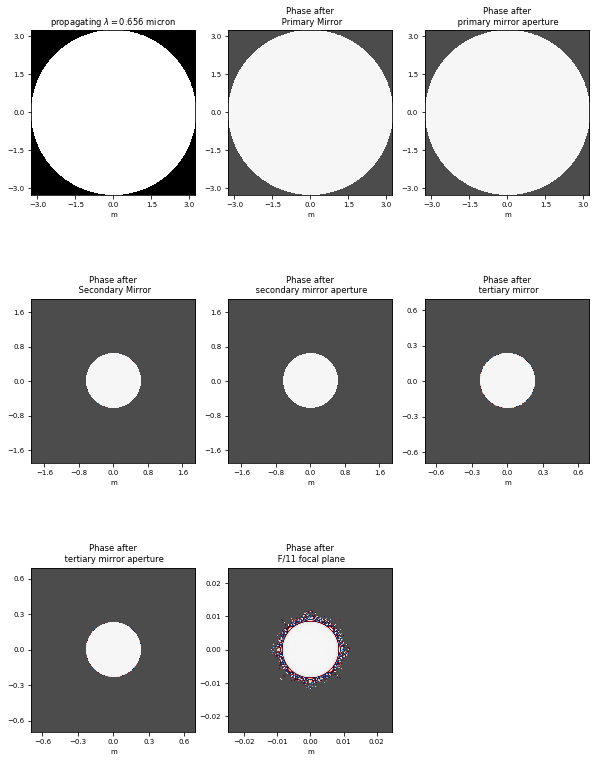

In [20]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
import matplotlib.rcsetup
psf, intermed_wfs = magaox.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

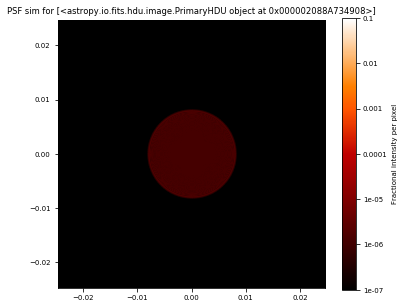

In [21]:
plt.figure(figsize=[6,5])
poppy.display_PSF(psf)

### Build to F/16 ASM Focal Plane

In [22]:
# Surface -2: OAP-0
magaox.add_optic(OAP0, distance=d_f11fp_oap0)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-0 aperture"))

# Surface -1: woofer mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="woofer mirror"), distance=d_oap0_woofer)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="woofer mirror aperture"))

# Surface 0: OAP-1
magaox.add_optic(OAP1, distance=d_woofer_oap1)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-1 aperture"))

# Surface 1: ASM F/16 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="ASM F/16 Focal Plane"), distance=d_oap1_asmfp)

# magaox.describe()

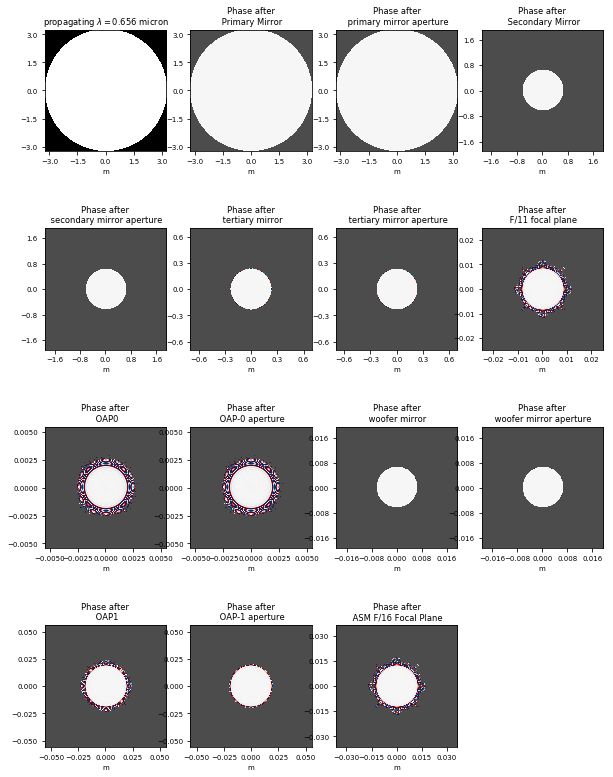

In [23]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
asmpsf, intermed_wfs = magaox.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

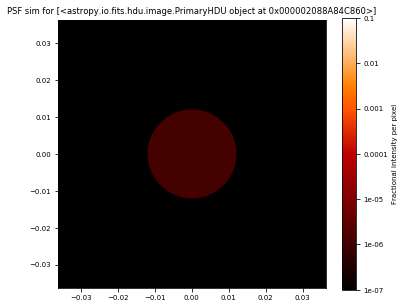

In [24]:
plt.figure(figsize=[6,5])
poppy.display_PSF(asmpsf)

### Build to F/57 Focal Plane (Surface 5)

In [25]:
# Surface 2: OAP-2
magaox.add_optic(OAP2, distance=d_asmfp_oap2)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-2 aperture"))

# Surface 3: tweeter mirror
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="tweeter mirror"), distance=d_oap2_tweeter)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius, name="tweeter mirror aperture"))

# SKIP: ADC1 at Surface 4&5

# Surface 4: OAP-3
magaox.add_optic(OAP3, distance=d_tweeter_oap3)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-3 aperture"))

# Surface 5: ASM F/57 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/57 Focal Plane"), distance=d_oap3_f57fp)

#magaox.describe()

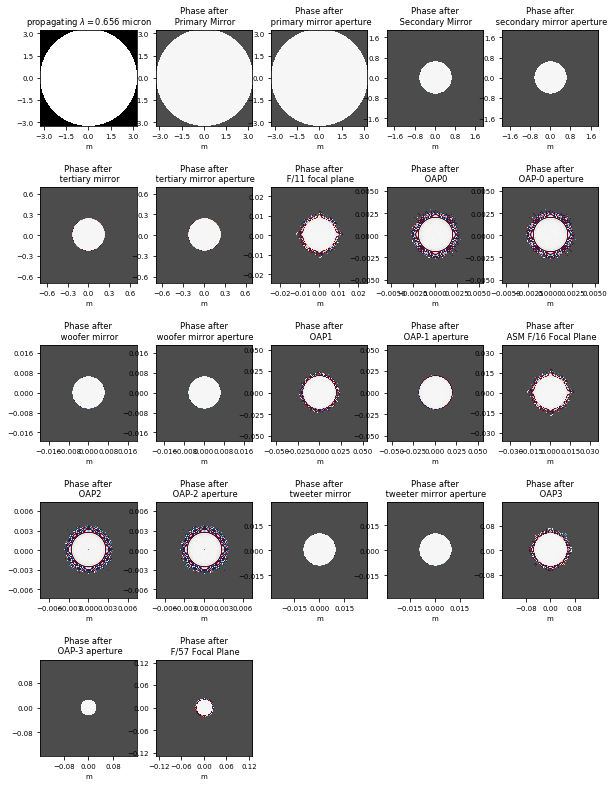

In [26]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
f57psf, intermed_wfs = magaox.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

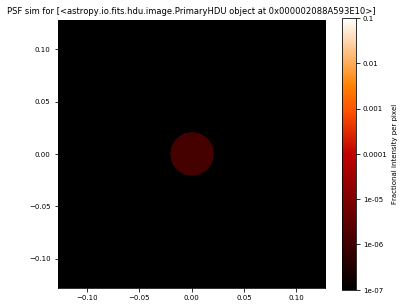

In [27]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f57psf)

### Build to F/69 Focal Plane (Surface 13)

In [28]:
# Surface 6: OAP-4
magaox.add_optic(OAP4, distance=d_f57fp_oap4)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-4 aperture"))

# SKIP: ADC1 (Surface 7&8), ADC2 (Surface 9&10)

# Surface 11: flat TT mirror (9mm pupil)
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm pupil flat TT mirror"), distance=d_oap4_ttmirror)
magaox.add_optic(poppy.CircularAperture(radius=0.0045*u.m, name="woofer mirror aperture"))

# Surface 12: OAP-5.1
magaox.add_optic(OAP5, distance=d_ttmirror_oap51)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #1 aperture"))

# Surface 13: F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane"), distance=d_oap51_f69fp)

#magoax.describe()

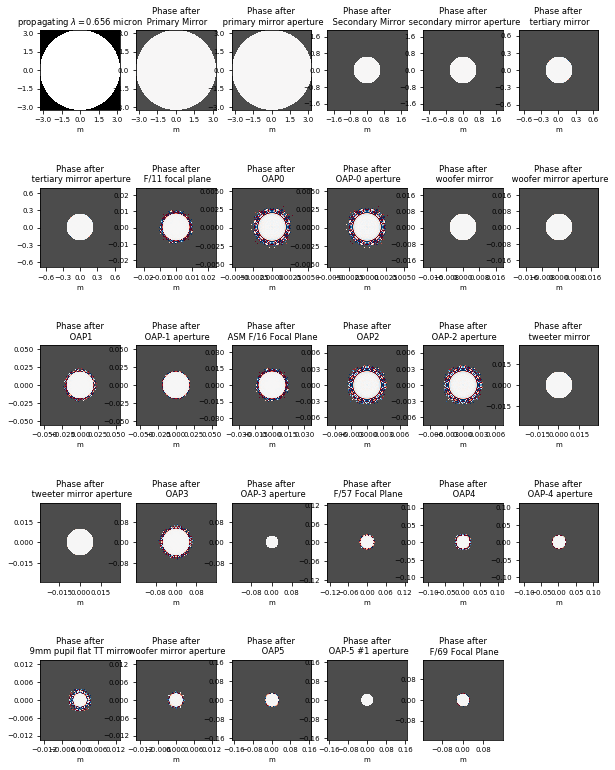

In [29]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
f69psf, intermed_wfs = magaox.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

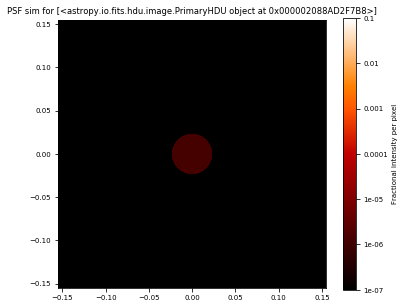

In [30]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f69psf)

### Build to Science F/69 Focal Plane

In [32]:
# Surface 14: OAP-5.2
magaox.add_optic(OAP5, distance=d_f69fp_oap52)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #2 aperture"))

# Surface 15: 9mm Lyot Stop
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="9mm Lyot Stop"), distance=d_oap52_lyot)
magaox.add_optic(lyotstop)

# Surface 16: OAP-5.3
magaox.add_optic(OAP5, distance=d_lyot_oap53)
magaox.add_optic(poppy.CircularAperture(radius=oap_radius,name="OAP-5 #3 aperture"))

# Surface 17: Science F/69 Focal Plane
magaox.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate, name="F/69 Focal Plane"), distance=d_oap53_f69sci)

magaox.describe()

	Entrance pupil diam:  6.478408 m	npix: 1024	Beam ratio:0.34
	Optic: Circle, radius=3.239204 m
	Lens: Primary Mirror, with focal length 8.13 m
	Optic: primary mirror aperture
	Propagation distance:  9.72205 m
	Lens: Secondary Mirror, with focal length 1.43141 m
	Optic: secondary mirror aperture
	Propagation distance:  9.02279 m
	Optic: tertiary mirror
	Optic: tertiary mirror aperture
	Propagation distance:  4.979516 m
	Optic: F/11 focal plane
	Propagation distance:  0.1434399617 m
	Lens: OAP0, with focal length 0.1434399616742 m
	Optic: OAP-0 aperture
	Propagation distance:  0.14437519 m
	Optic: woofer mirror
	Optic: woofer mirror aperture
	Propagation distance:  0.2107263437 m
	Lens: OAP1, with focal length 0.2107263436959 m
	Optic: OAP-1 aperture
	Propagation distance:  0.2107263437 m
	Optic: ASM F/16 Focal Plane
	Propagation distance:  0.3136327727 m
	Lens: OAP2, with focal length 0.3136327726755 m
	Optic: OAP-2 aperture
	Propagation distance:  0.3136327727 m
	Optic: tweeter mirror


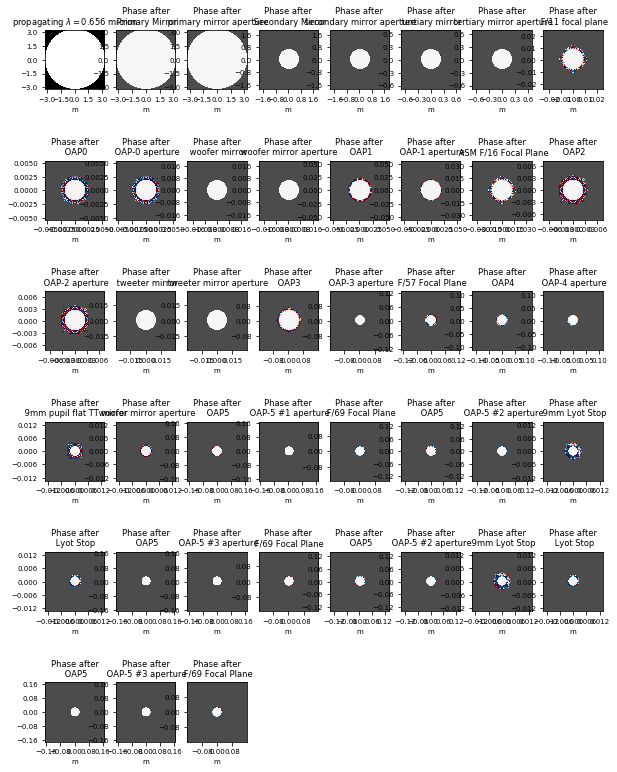

In [33]:
matplotlib.rcParams["font.size"]=7
plt.figure(figsize=[10,14])
f69scipsf, f69sci_wfs = magaox.calcPSF(wavelength=testWavelength,
                                      display_intermediates=True,
                                      return_intermediates=True)

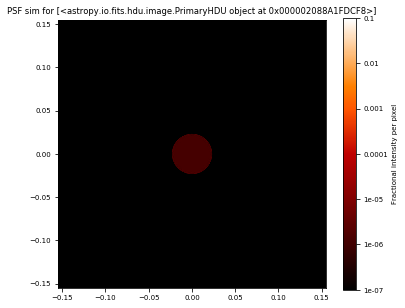

In [34]:
plt.figure(figsize=[6,5])
poppy.display_PSF(f69scipsf)